In [1]:
from scipy.interpolate import griddata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../measurements/JPEG_manager_dyanmic2/characteristic.csv")

In [3]:
df.head()

,pruning_thresh,quality,technique,bandwidth,mAP_drop,frame_id,sparsity,decomposability,regularity,pictoriality,datasize_est,datasize_real,reconstruct_snr,target_cmp,target_snr
0,0.05,92,1,2.498029e+07,40,1,-1,-1,-1,-1,38398,39142,13.467377,18.473873,20
1,0.05,92,1,2.492123e+07,40,2,-1,-1,-1,-1,28669,29413,19.505306,18.517654,20
2,0.05,92,1,2.482305e+07,40,3,-1,-1,-1,-1,27481,28225,23.767583,18.590892,20
3,0.05,92,1,2.468615e+07,40,4,-1,-1,-1,-1,19647,20391,23.742502,18.693992,20
4,0.05,92,1,2.451106e+07,40,5,-1,-1,-1,-1,10792,11536,22.784839,18.827530,20


In [4]:
jpeg_cha = pd.read_csv("/home/rex/gitRepo/split_DNN_framework/stable_tests/measurements/jpeg_snr_cha/characteristic.csv")

In [9]:
test ={}

In [94]:
jpeg_cha = pd.read_csv("/home/rex/gitRepo/split_DNN_framework/stable_tests/measurements/jpeg_snr_cha/characteristic.csv")
jpeg_cha = jpeg_cha[jpeg_cha["sparsity"]>0]
jpeg_cha = jpeg_cha[jpeg_cha["datasize_est"]>0]
tensor_size = 128*26*26 *4
jpeg_cha["ratio"] = tensor_size/jpeg_cha["datasize_est"]
pruning = [0.05, 0.1, 0.15, 0.2, 0.25,0.3,0.35]
quality = [60,70,80,90,100]

snr_samples ={}
cmp_samples ={}
window_size = 10

cha_df_group =jpeg_cha.groupby("pruning_thresh")
for p in pruning:
    cha_df = cha_df_group.get_group(p)
    cha_quality_df = cha_df.groupby("quality")
    for q in quality:
        cha_plot_df= cha_quality_df.get_group(q)
        snrs = cha_plot_df["reconstruct_snr"].to_numpy()[0:window_size]
        cmps = cha_plot_df["ratio"].to_numpy()[0:window_size]
        snr_samples[(p,q)] =snrs
        cmp_samples[(p,q)] =cmps


In [95]:
thresh = df["pruning_thresh"].to_numpy()
quality = df["quality"].to_numpy()
snr_m = df["reconstruct_snr"].to_numpy()

In [96]:
est_err = []
est_all = []

for i in range(len(thresh)):
    sample_points = list(snr_samples.keys())
    sample_snrs = np.max(np.array(list(snr_samples.values())),axis=1)
    # snr_est = griddata(sample_points, sample_snrs, (thresh[i],quality[i]), method='cubic')
    snr_est = griddata(sample_points, sample_snrs, (thresh[i],quality[i]), method='linear')
    est_all.append(snr_est)
    est_err.append(snr_est-snr_m[i])

    try:
        values = snr_samples[(thresh[i],quality[i])]
        values = np.roll(values,1)
        values[0] = snr_m[i]
        snr_samples[(thresh[i],quality[i])] = values
    except:
        snr_samples[(thresh[i],quality[i])] = np.ones(window_size)*snr_m[i]




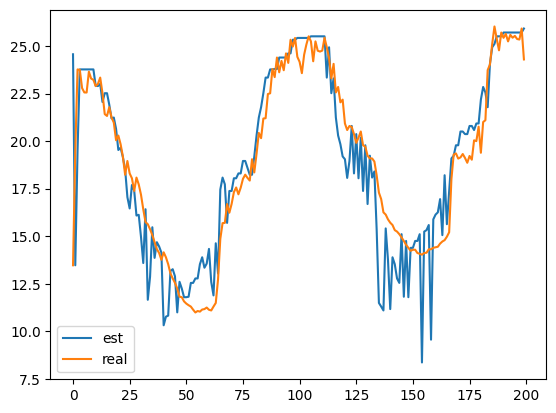

In [97]:
plt.figure()
plt.plot(est_all, label = "est")
plt.plot(snr_m, label = "real")
plt.legend()

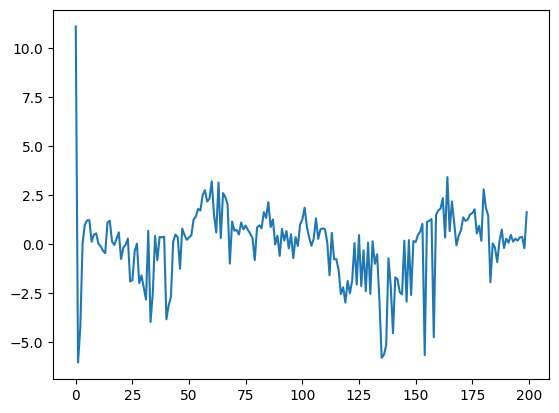

In [98]:
plt.figure()
plt.plot(est_err)

In [7]:
est_err_window = []
est_snr_window = []
window_size = 3
history_point = []
history_snr =[]

for i in range(len(thresh)):
    sample_points = sample_space+history_point
    sample_snrs = sample_space_snr +history_snr
    # snr_est = griddata(sample_points, sample_snrs, (thresh[i],quality[i]), method='cubic')
    snr_est = griddata(sample_points, sample_snrs, (thresh[i],quality[i]), method='cubic')
    est_snr_window.append(snr_est)
    est_err_window.append(snr_est-snr_m[i])

    if len(history_point)<window_size:
        history_point.append((thresh[i],quality[i]))
        history_snr.append(snr_m[i])
    else:
        index = i%window_size
        history_point[index] = (thresh[i],quality[i])
        history_snr[index] =  snr_m[i]


In [8]:
est_err_window2 = []
est_snr_window2 = []
window_size = 20
history_point2 = []
history_snr2 =[]

for i in range(len(thresh)):
    sample_points = sample_space+history_point2
    sample_snrs = sample_space_snr +history_snr2
    # snr_est = griddata(sample_points, sample_snrs, (thresh[i],quality[i]), method='cubic')
    snr_est = griddata(sample_points, sample_snrs, (thresh[i],quality[i]), method='cubic')
    est_snr_window2.append(snr_est)
    est_err_window2.append(snr_est-snr_m[i])

    if len(history_point2)<window_size:
        history_point2.append((thresh[i],quality[i]))
        history_snr2.append(snr_m[i])
    else:
        index = i%window_size
        history_point2[index] = (thresh[i],quality[i])
        history_snr2[index] =  snr_m[i]

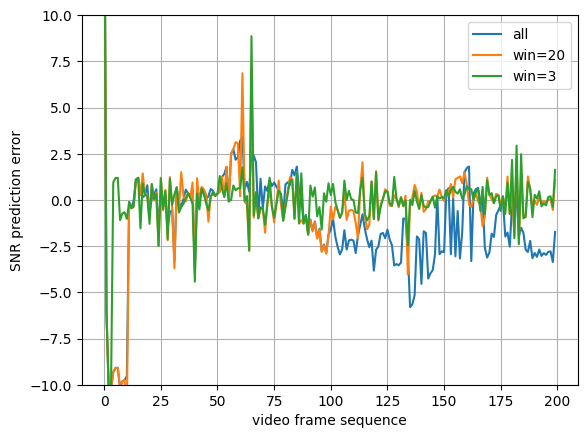

In [14]:
plt.figure()
plt.plot(est_err, label="all")
plt.plot(est_err_window2,label="win=20")
plt.plot(est_err_window,label="win=3")
plt.legend()
plt.xlabel("video frame sequence")
plt.ylabel("SNR prediction error")
plt.ylim([-10,10])
plt.grid()

Text(0.5, 0, 'video frame sequence')

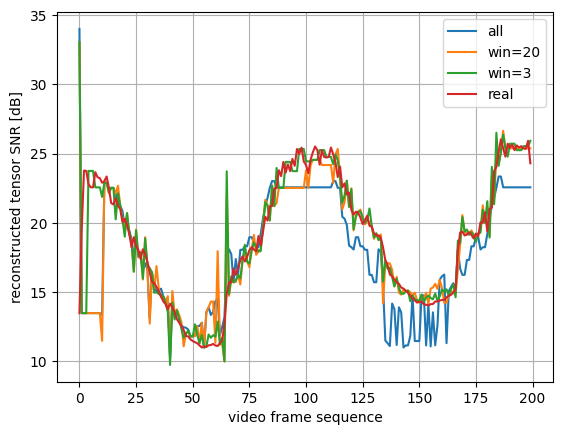

In [21]:
plt.figure()
plt.plot(est_all, label ="all")
plt.plot(est_snr_window2,label="win=20")
plt.plot(est_snr_window,label="win=3")
plt.plot(snr_m,label="real")
plt.legend()
plt.grid()
plt.ylabel("reconstructed tensor SNR [dB]")
plt.xlabel("video frame sequence")

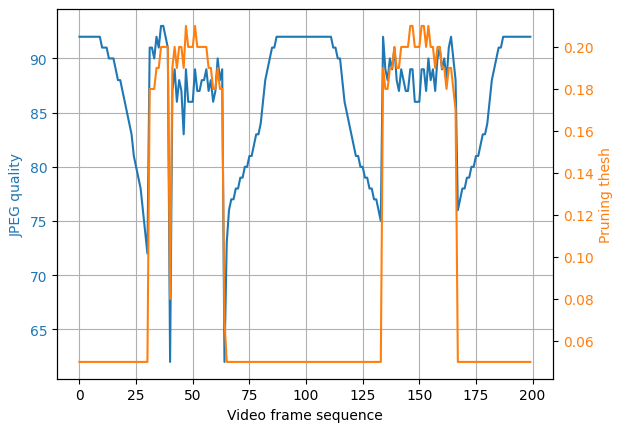

In [22]:
fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('Video frame sequence')
ax1.set_ylabel('JPEG quality', color=color)

ax1.tick_params(axis='y', labelcolor=color)

# feasibility = map_df["feasible"].to_numpy()
# for i in range(len(feasibility)):
#     if feasibility[i] == 1:
#         ax1.axvspan(i, i+1, facecolor='tab:green', alpha=0.3)
#     else:
#         ax1.axvspan(i, i+1, facecolor='tab:pink', alpha=0.3)
ax1.plot(quality,color=color)
ax1.grid()
ax2 = ax1.twinx() 
color = 'tab:orange'
ax2.set_ylabel('Pruning thesh', color=color)  # we already handled the x-label with ax1
ax2.plot(thresh, color=color)
ax2.tick_params(axis='y', labelcolor=color)
